# Encoders: Binary Example
One of the interesting Neural Net Architectures are auto-encoders. Auto-encoders are networks designed to predict their own input. An auto-encoder consists of an `encoder` which encodes the input to a set of __latent variables__ and a `decoder` which decodes the latent variables and tries to reconstruct the full input. It can be thought of as the `encoder` compressing the input into a lower dimensional representation and then the `decoder` de-compressing that lower dimensional representation back to the size of the input. The loss indicates how close it got to the original input. Higher loss means the model had more difficulty reconstructing the initial input

Initially this may sound like somewhat of a trivial exercise. But auto-encoders have some potentially interesting use cases. Auto-encoders do not need Fraud labels, the input is the label. In order to train an auto-encoder you only need transactions. Auto-encoders might potentially be used for:
- __Anomaly detection__. If the loss after reconstruction is high we could assume that it is something the model did not really see before. I might be an anomaly.
- __Transfer learning__. Transfer learning is an interesting concept where part of what is learned in one model (the latent features) is transferred into another model. It's used quite extensively in NLP and image recognition. Where models are pre-trained on very large data sets and then 'fine-tune' for specific tasks on much smaller data sets. We could train an auto-encoder. Then throw away the de-coder and replace it with a classifier and 'fine-tune' the model.

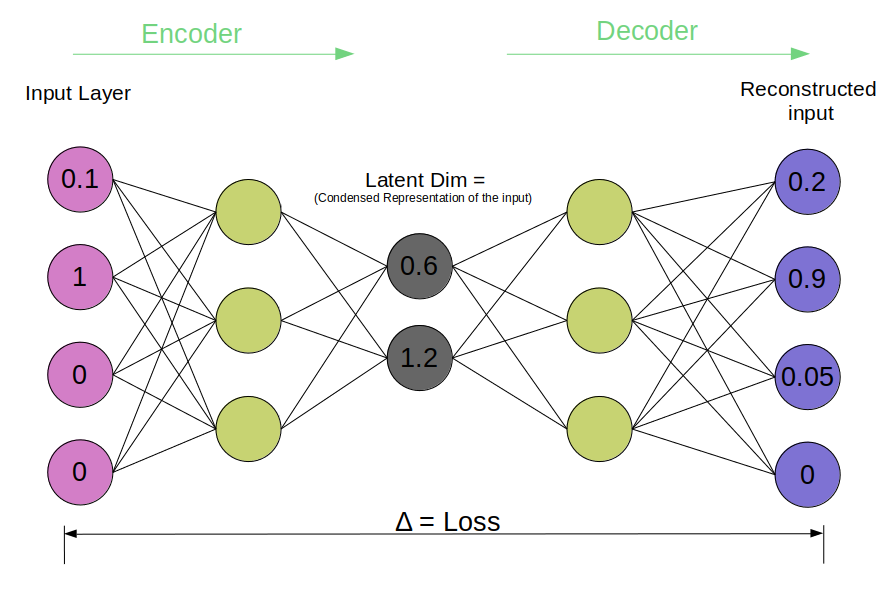

----
#### Note on the data set 
The data set used here is not particularly complex and/or big. It's not really all that challenging to find the fraud. In an ideal world we'd be using more complex data sets to show the real power of Deep Learning. There are a bunch of PCA'ed data sets available, but the PCA obfuscates some of the elements that are useful. 
*These examples are meant to show the possibilities, it's not so useful to interpret their performance on this data set*

# Imports

In [1]:
import torch
import numpy as np
import gc

import d373c7.features as ft
import d373c7.engines as en
import d373c7.pytorch as pt
import d373c7.pytorch.models as pm
import d373c7.plot as pl

## Set a random seed for Numpy and Torch
> Will make sure we always sample in the same way. Makes it easier to compare results. At some point it should been removed to test the model stability.

In [2]:
# Numpy
np.random.seed(42)
# Torch
torch.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Define base feature and read the File
The base features are features found in the input file. They need to be defined after which the file can be read using the `EnginePandasNumpy`. Using the `from_csv` method.
The `from_csv` method will read the file and return a Pandas DataFrame object

In [3]:
# Change this to read from another location
file = '../../../data/bs140513_032310.csv'

Other than with the previous examples, we do not use the amount as such. We use a `FeatureBin` feature which will 'bin' the features into ranges. We've asked for 30 bins. So the amount at this point is no longer a continuous variable but an integer number between 1 and 30.

We do this because we'll be able to use all binary input, calculating the loss on that is easier than if we'd also have continuous features (we'd have to start mixing various loss functions)

We then take that *binned* amount and convert it into a one-hot encoded variable. That turns the 1 to 30 number and makes 30 columns out of it. The amount thus undergoes 2 transformations. First from number to bin, then from bin to one-hot encoded.

All input features are one-hot encoded, we get a pure __binary__ input, 108 columns, 107 of which are the binary one-hot encoded features and 1 is the label.

In [4]:
age = ft.FeatureSource('age', ft.FEATURE_TYPE_CATEGORICAL)
gender = ft.FeatureSource('gender', ft.FEATURE_TYPE_CATEGORICAL)
merchant = ft.FeatureSource('merchant', ft.FEATURE_TYPE_CATEGORICAL)
category = ft.FeatureSource('category', ft.FEATURE_TYPE_CATEGORICAL)
amount = ft.FeatureSource('amount', ft.FEATURE_TYPE_FLOAT)
fraud = ft.FeatureSource('fraud', ft.FEATURE_TYPE_INT_8)

amount_binned = ft.FeatureBin('amount_bin', ft.FEATURE_TYPE_INT_16, amount, 30)

amount_oh = ft.FeatureOneHot('amount_one_hot', ft.FEATURE_TYPE_INT_8, amount_binned)
age_oh = ft.FeatureOneHot('age_one_hot', ft.FEATURE_TYPE_INT_8, age)
gender_oh = ft.FeatureOneHot('gender_one_hot', ft.FEATURE_TYPE_INT_8, gender)
merchant_oh = ft.FeatureOneHot('merchant_one_hot', ft.FEATURE_TYPE_INT_8, merchant)
category_oh = ft.FeatureOneHot('category_one_hot', ft.FEATURE_TYPE_INT_8, category)
fraud_label = ft.FeatureLabelBinary('fraud_label', ft.FEATURE_TYPE_INT_8, fraud)

learning_features = ft.TensorDefinition(
    'learning', 
    [
        age_oh,
        gender_oh,
        merchant_oh,
        category_oh,
        amount_oh
    ])

label = ft.TensorDefinition('label', [fraud_label])

model_features = ft.TensorDefinitionMulti([learning_features, label])

with en.EnginePandasNumpy() as e:
    ft_df = e.from_csv(learning_features, file, inference=False)
    lb_df = e.from_csv(label, file, inference=False)

# Display the learning Dataframe.
ft_df

2021-09-17 13:15:34.413 d373c7.engines.common          INFO     Start Engine...
2021-09-17 13:15:34.413 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2021-09-17 13:15:34.414 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2021-09-17 13:15:34.414 d373c7.engines.panda_numpy     INFO     Building Panda for : learning from file ../../../data/bs140513_032310.csv
2021-09-17 13:15:34.649 d373c7.engines.panda_numpy     INFO     Building Panda for : <Source_Derive_Source> from DataFrame. Inference mode <False>
2021-09-17 13:15:34.650 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Source_Derive_Source
2021-09-17 13:15:34.652 d373c7.engines.panda_numpy     INFO     Done creating Source_Derive_Source. Shape=(594643, 5)
2021-09-17 13:15:34.782 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: learning
2021-09-17 13:15:34.809 d373c7.engines.panda_numpy     INFO     Building Panda for : label from file ../../../data/bs140513_032310.csv
20

,age__0,age__1,age__2,age__3,age__4,age__5,age__6,age__U,gender__E,gender__F,...,amount_bin__21,amount_bin__22,amount_bin__23,amount_bin__24,amount_bin__25,amount_bin__26,amount_bin__27,amount_bin__28,amount_bin__29,amount_bin__0
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594638,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
594639,0,0,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
594640,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
594641,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Convert to Numpy

> Slightly different than with the classifiers examples, we now only have 2 lists. One contains all the input data as binary representations (the one-hot encoded variables), there's 107 of them in total. The second list contains the fraud label

In [5]:
with en.EnginePandasNumpy() as e:
    ft_np = e.to_numpy_list(learning_features, ft_df)
    lb_np = e.to_numpy_list(label, lb_df)

data_list = en.NumpyList(ft_np.lists + lb_np.lists)
print(data_list.shapes)
print(data_list.dtype_names)

2021-09-17 13:15:39.266 d373c7.engines.common          INFO     Start Engine...
2021-09-17 13:15:39.266 d373c7.engines.panda_numpy     INFO     Pandas Version : 1.1.4
2021-09-17 13:15:39.266 d373c7.engines.panda_numpy     INFO     Numpy Version : 1.19.2
2021-09-17 13:15:39.267 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: int8
2021-09-17 13:15:39.267 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Binary
2021-09-17 13:15:39.304 d373c7.engines.panda_numpy     INFO     Converting DataFrame to Numpy of type: int8
2021-09-17 13:15:39.304 d373c7.engines.panda_numpy     INFO     Reshaping DataFrame to: Label


[(594643, 107), (594643,)]
['int8', 'int8']


## Wrangle the data
Time split the data. For time series data it is very important to keep the order of the data. This split will start from the end and work it's way to the front of the data. This way the training, validation and test data are nicely colocated in time

> 1. Split out a test-set of size `test_records`. This is used for model testing.
> 2. Split out a validation-set of size `validation_records`. It will be used to monitor overfitting during training
> 3. All the rest is considered training data.

__Important__. For auto-encoders we perform a 4th step, all fraud records will be removed from the training and validation data. The auto-encoder will only see *non-fraud* records during training.
> 4. Remove fraud records from training and validation

In [6]:
test_records = 100000
val_records  = 30000 

train_data, val_data, test_data = data_list.split_time(val_records, test_records) 

# Filter. Only keep non-fraud records with label 0. 
train_data = train_data.filter_label(model_features, 0)
val_data = val_data.filter_label(model_features, 0)

print(f'Training Data shapes {train_data.shapes}')
print(f'Validation Data shapes {val_data.shapes}')
print(f'Test Data shapes {test_data.shapes}')
del data_list, ft_df, lb_df, ft_np, lb_np
gc.collect()
print('Done')

Training Data shapes [(458847, 107), (458847,)]
Validation Data shapes [(29670, 107), (29670,)]
Test Data shapes [(100000, 107), (100000,)]
Done


## Set up Devices

In [7]:
device, cpu = pt.init_devices()

2021-09-17 13:15:43.353 d373c7.pytorch.common          INFO     Torch Version : 1.9.0+cu111
2021-09-17 13:15:43.421 d373c7.pytorch.common          INFO     GPU found. Using GPU <0>
2021-09-17 13:15:43.422 d373c7.pytorch.common          INFO     Cuda Version  : 11.1


## Define model

> Define a __GeneratedAutoEncoder__. As input it takes the size of the latent dimension. In this case *3*. And it takes a list of integers indicating the number and the size of the hidden dimensions. *We are defining it to have 1 hidden layer of size 16*.

> Though the training and validation data-loaders contain the fraud label, auto-encoders will ignore it. It is not used in the model. Auto-encoders ignore fields defined as `LearningCategoryLabel`

> The model will use BinaryCrossEntropy to measure the loss. The entire 107 output will be compared to input, sort of like a *107 class* classifier. By using binary cross entropy over the entire input, we do allow features with more cardinality to incur bigger losses. It may turn out this model prefers getting it right for higher cardinality features such as __merchant__ over lower cardinality features such as __age__.

In [8]:
# Setup Pytorch Datasets for the training and validation
batch_size = 128
train_ds = pt.NumpyListDataSetMulti(model_features, train_data)
val_ds = pt.NumpyListDataSetMulti(model_features, val_data)

# Wrap them in a Pytorch Dataloader
train_dl = train_ds.data_loader(cpu, batch_size, num_workers=2, shuffle=True)
val_dl = val_ds.data_loader(cpu, batch_size, num_workers=2)

# Create a model
m = pm.GeneratedAutoEncoder(model_features, linear_layers=[16], latent_features=3)
print(m)

GeneratedAutoEncoder(
  Number of parameters : 3662. Loss : SingleLabelBCELoss,  mean
  (streams): ModuleList(
    (0): Sequential(
      (learning): TensorDefinitionHead(lcs=['Binary'])
      (encoder): LinearEncoder(
        (layers): Sequential(
          (enc_lin_01): Linear(in_features=107, out_features=16, bias=True)
          (enc_act_01): ReLU()
          (enc_dropout_01): Dropout(p=0.1, inplace=False)
          (enc_latent): Linear(in_features=16, out_features=3, bias=True)
        )
      )
      (decoder): LinearDecoder(
        (layers): Sequential(
          (dec_lin_01): Linear(in_features=3, out_features=16, bias=True)
          (dec_act_01): ReLU()
          (dec_dropout_01): Dropout(p=0.1, inplace=False)
        )
      )
      (out_lin): Linear(in_features=16, out_features=107, bias=True)
      (out_sigmoid): Sigmoid()
    )
  )
)


#### Graphically above network looks more or less like this...

> The Binary input is condensed to 3 latent features using 1 linear layer by the Encoder. The Decoder takes the latent feature and expands them again to the size of the original input. The loss is measured using BinaryCrossEntropy.

*(Dropout, Relu and Sigmoid layers were omitted for simplicity)

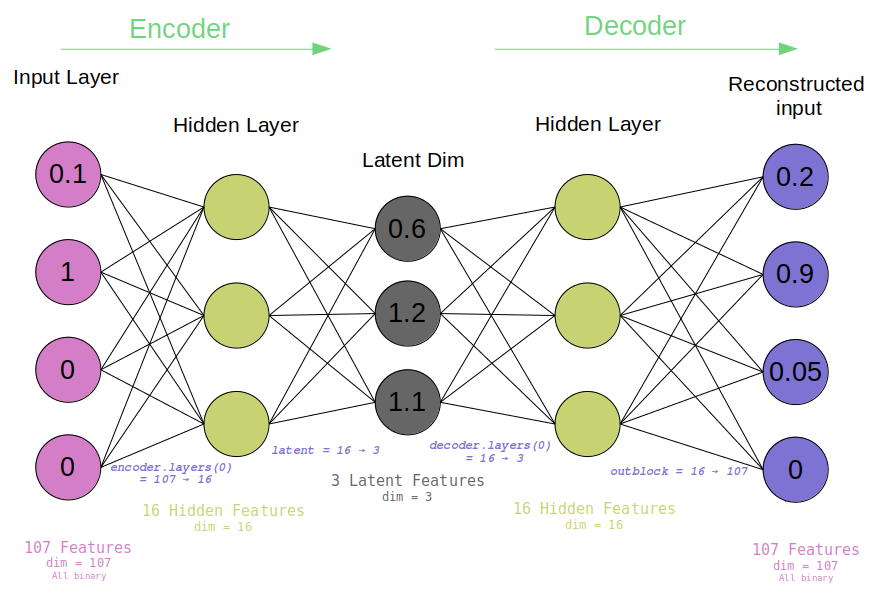

### First find a decent Learning Rate. 
> Create a trainer and run the find_lr function and plot. 

2021-09-17 13:15:49.678 d373c7.pytorch.training        INFO     Saving model under ./temp_model.pt
Finding LR in 200 steps: 100%|██████████| 200/200 [00:00<00:00, 483.34it/s]
2021-09-17 13:15:52.465 d373c7.pytorch.training        INFO     Restoring model from ./temp_model.pt


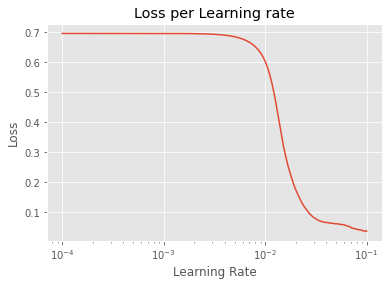

In [9]:
t = pt.Trainer(m, device, train_dl, val_dl)
r = t.find_lr(1e-4, 1e-1, 200)
pl.TrainPlot().plot_lr(r)

### Start Training and plot the results
> We train for __5 epochs__ and __learning rate 8e-3__. We use a slightly higher learning rate. It turns out that using small learning rates tends to lead to worse results. Might be over-fit. More on this later

Epoch 005/005: 100%|██████████| 3817/3817 [00:05<00:00, 709.46it/s, train_loss=0.0092, val_loss=0.0051]


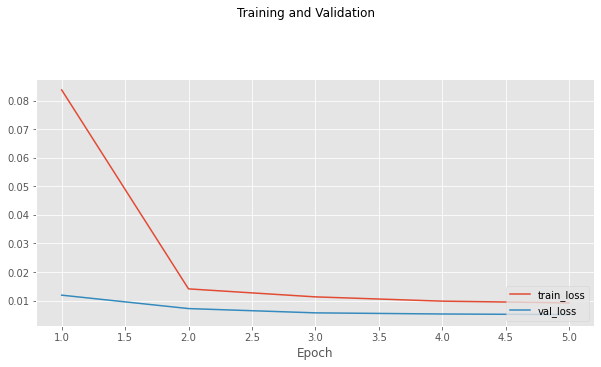

In [10]:
t = pt.Trainer(m, device, train_dl, val_dl)
h = t.train_one_cycle(5, 8e-3)
pl.TrainPlot().plot_history(h, fig_size=(10,10))

## Test the Model
Ready to test. We use the score_plot() method. Our model will output the reconstructed output, i.e. 107 binary numbers per record. The score method will apply the same loss logic as during training, that means the score is the __reconstruction loss__ for each record. The *higher* the score, the *less* successful the model was in reconstructing the original input.

Other than the training and the validation set, the test set __does contain fraud records__. So we can now test if the score (the reconstruction loss) is predictive of fraud. 

It is important to understand that this will flag *anomalies*, things the model has not seen that often. However being anomalous does __not__ mean a record is *fraud*. People do have transactions that are weird, out of the normal, but not fraud. And the inverse also holds, fraud records can be made to look very much like good transactions.

> - In the Score Histogram we can see how many record are fraud vs non-fraud for the range of scores. The scale of the y axis is __logarithmic__, the amount of fraud records is very low, on a normal scale they barely show.
> - The second plot shows how various metrics change with the threshold. We seem to get optimum f1/f2 scores around 0.1
> - The 3rd and 4th plot show the classification and confusion matrix at the threshold of 0.1. (For the classifiers, we plotted with the default 0.5 threshold)
> - The rest is the same as the classifiers, they do not take a threshold into account

Creating Scores in 782 steps: 100%|██████████| 782/782 [00:00<00:00, 1355.98it/s]


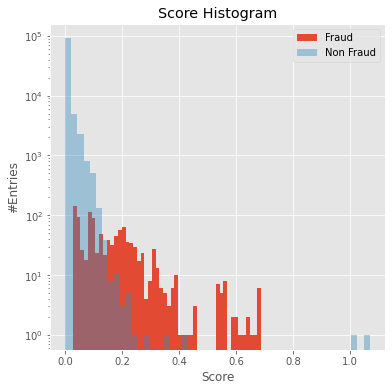

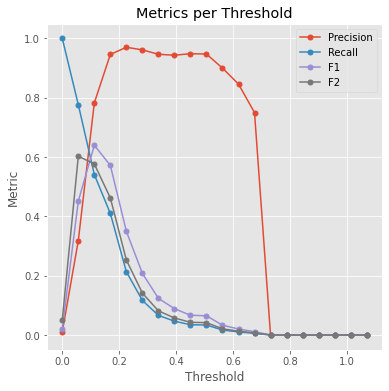

------------- Classification report -----------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     98926
         1.0       0.71      0.60      0.65      1074

    accuracy                           0.99    100000
   macro avg       0.85      0.80      0.82    100000
weighted avg       0.99      0.99      0.99    100000


auc score : 0.9879
ap score  : 0.6811
-----------------------------------------------------


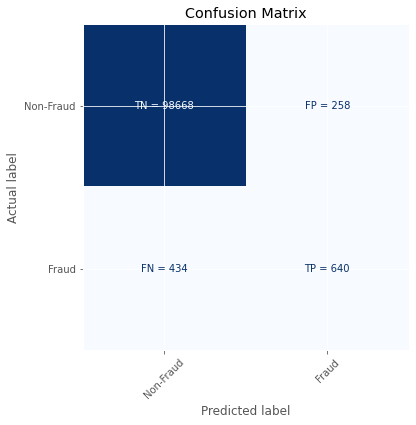

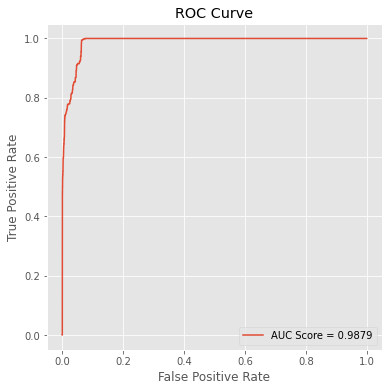

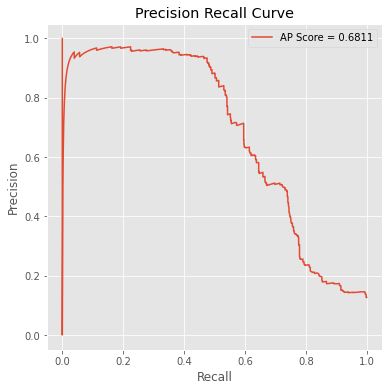

In [11]:
test_ds = pt.NumpyListDataSetMulti(model_features, test_data)
test_dl = test_ds.data_loader(cpu, 128, num_workers=2)

ts = pt.Tester(m, device, test_dl)
tp = pl.TestPlot()
r = ts.score_plot()
tp.plot_scores(r, 50, fig_size=(6,6))
tp.plot_score_metrics(r, 20, fig_size=(6,6))
tp.print_classification_report(r, threshold=0.1)
tp.plot_confusion_matrix(r, fig_size=(6,6), threshold=0.1)
tp.plot_roc_curve(r, fig_size=(6,6))
tp.plot_precision_recall_curve(r, fig_size=(6,6))

# Conclusion
This was a simple encoder example, it was trained without ever seeing a Fraud record. As is the case with all the examples on this simple dataset it has to be taken with a grain of salt. 

For this data we were able to train a model to look for *anomalies*, transactions it found difficult to reconstruct. It turns out that in general the fraud records were more difficult to reconstruct and had higher scores.